In [1]:
pip -q install SciencePlots

Note: you may need to restart the kernel to use updated packages.


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import os

In [4]:
from gnd.src import basis, data

In [5]:
plt.style.use('science')
fontsize_title=22
fontsize_label=18
fontsize_legend=16
fontsize_ticks=16

In [6]:
def plot_comparison(num_steps_gnd, num_steps_sgd, num_steps_jaxgd, ntrials, name, title):
    plt.figure(figsize=(8,5))
#     plt.title(title, fontsize=fontsize_title)
    plt.hist(num_steps_gnd, bins=[i+1 for i in range(110)], alpha=0.5, label="Geodesic algorithm")
    plt.hist(num_steps_sgd, bins=[i+1 for i in range(110)], alpha=0.5, label="Stochastic gradient descent")
    plt.hist(num_steps_jaxgd, bins=[i+1 for i in range(110)], alpha=0.5, label="Gradient descent")
    plt.xticks([0,20,40,60,80,100], fontsize=fontsize_ticks)

    plt.xlabel("Steps to solution", fontsize=fontsize_label)
    plt.ylabel(f"Number of solutions", fontsize=fontsize_label)
    plt.legend(fontsize=fontsize_legend)
    plt.savefig(f"{name}.pdf", bbox_inches='tight')
    plt.show()

In [18]:
def plot_fidelity(num_steps_gnd, max_fidelity_gnd, name, title):

    plt.figure(figsize=(4,4))
    plt.title(title, fontsize=fontsize_title)
    plt.scatter(num_steps_gnd, 1-  np.abs(max_fidelity_gnd), alpha=0.5, s=50)
    plt.xlabel(f"Steps to solution", fontsize=fontsize_label)
    plt.ylabel(f"Maximum infidelity", fontsize=fontsize_label)
    plt.yscale('log')
    plt.xscale('log')
    plt.xlim(1, 10**4+1000)
    plt.ylim(1e-6, 1.)
    plt.savefig(f"{name}.pdf", bbox_inches='tight')
    plt.show()

In [12]:
def get_data_comparison(config, config_gnd, seeds):
    num_steps_gnd = []
    num_steps_sgd = []
    num_steps_jaxgd = []
    max_fidelity_gnd = []
    max_fidelity_sgd = []
    max_fidelity_jaxgd = []
    for seed in seeds:
        print(f"Collecting data for seed: {seed}", end="\r")
        config.seed = seed        
        config_gnd.seed = seed

        dat_gnd = data.OptimizationData(config_gnd, optimizers=[], load_data=True, folder="gnd/data")
        if dat_gnd.samples > 0:
            num_steps_gnd.append(dat_gnd.steps(1)[-1])
            max_fidelity_gnd.append(dat_gnd.max_fidelity(1))
        dat_sgd = data.OptimizationData(config, optimizers=[], load_data=True, folder="innocenti/data")
        if dat_sgd.samples > 0:
            num_steps_sgd.append(dat_sgd.steps(1)[-1])
            max_fidelity_sgd.append(dat_sgd.max_fidelity(1))
        dat_jaxgd = data.OptimizationData(config, optimizers=[], load_data=True, folder="jax_gd/data")
        if dat_jaxgd.samples > 0:
            num_steps_jaxgd.append(dat_jaxgd.steps(1)[-1])
            max_fidelity_jaxgd.append(dat_jaxgd.max_fidelity(1))
    print(f"Data integrity:\n"
          f"GND: {len(num_steps_gnd)}/{len(seeds)}\n"
          f"Innocenti: {len(num_steps_sgd)}/{len(seeds)}\n"
          f"Jax GD: {len(num_steps_jaxgd)}/{len(seeds)}\n")
    max_fidelity_gnd = np.array(max_fidelity_gnd)
    max_fidelity_sgd = np.array(max_fidelity_sgd)
    max_fidelity_jaxgd = np.array(max_fidelity_jaxgd)
    num_steps_gnd = np.array(num_steps_gnd)
    num_steps_sgd = np.array(num_steps_sgd)
    num_steps_jaxgd = np.array(num_steps_jaxgd)

    print(f"Number of solutions with fidelity {config.precision}:\n"
          f"GND: {sum(max_fidelity_gnd >= config.precision)}/{len(max_fidelity_gnd)}\n"
          f"Innocenti: {len(max_fidelity_sgd >= config.precision)}/{len(max_fidelity_sgd)}\n"
          f"Jax GD: {sum(max_fidelity_jaxgd >= config.precision)}/{len(max_fidelity_jaxgd)}\n")
    print("Mean time to solution", np.mean(num_steps_gnd[max_fidelity_gnd >= config.precision]))
    print("Mean time to solution", np.mean(num_steps_sgd[max_fidelity_sgd >= config.precision]))
    print("Mean time to solution", np.mean(num_steps_jaxgd[max_fidelity_jaxgd >= config.precision]))
    
    return num_steps_gnd, num_steps_sgd, num_steps_jaxgd

In [42]:
def get_data_fidelity(config, seeds):
    num_steps_gnd = []
    max_fidelity_gnd = []

    for seed in seeds:
        print(f"Collecting data for seed: {seed}", end="\r")
        config.seed = seed        
        dat_gnd = data.OptimizationData(config, optimizers=[], load_data=True, folder="gnd/data")
        if dat_gnd.samples > 0:
            max_fidelity_gnd.append(dat_gnd.max_fidelity(1))
            num_steps_gnd.append(dat_gnd.steps(1)[-1])
    print(f"Data integrity:\n"
          f"GND: {len(num_steps_gnd)}/{len(seeds)}")
    return num_steps_gnd, max_fidelity_gnd

def get_data_fidelity_trajectories(config, seeds):
    num_steps_gnd = []
    max_fidelity_gnd = []

    for seed in seeds:
        print(f"Collecting data for seed: {seed}", end="\r")
        config.seed = seed        
        dat_gnd = data.OptimizationData(config, optimizers=[], load_data=True, folder="gnd/data")
        if dat_gnd.samples > 0:
            max_fidelity_gnd.append(dat_gnd.fidelities(1))
            num_steps_gnd.append(dat_gnd.steps(1))
    print(f"Data integrity:\n"
          f"GND: {len(num_steps_gnd)}/{len(seeds)}")
    return num_steps_gnd, max_fidelity_gnd

# Data aggregation

In [6]:
loaded_data = {}

# Toffoli

### Commuting

In [13]:
from gnd.src.configs import ToffoliConfig as ToffoliConfigGnd
from jax_gd.src.configs import ToffoliConfig

config = ToffoliConfig()
config_gnd = ToffoliConfigGnd()

gate = 'toffoli'
ntrials = 1000
commute = True
max_steps = 1000

config.max_steps = max_steps
config_gnd.max_steps = max_steps
config_gnd.commute = commute

seeds = [n*256 for n in range(1,ntrials+1,1)] 

num_steps_gnd, num_steps_sgd, num_steps_jaxgd = get_data_comparison(config, config_gnd, seeds)
loaded_data[f"{gate}_{ntrials}_{commute}_{max_steps}"] = (num_steps_gnd, num_steps_sgd, num_steps_jaxgd)

Data integrity: for seed: 256000
GND: 1000/1000
Innocenti: 986/1000
Jax GD: 1000/1000

Number of solutions with fidelity 0.999:
GND: 1000/1000
Innocenti: 986/986
Jax GD: 981/1000

Mean time to solution 3.169
Mean time to solution 13.626774847870182
Mean time to solution 80.85117227319063


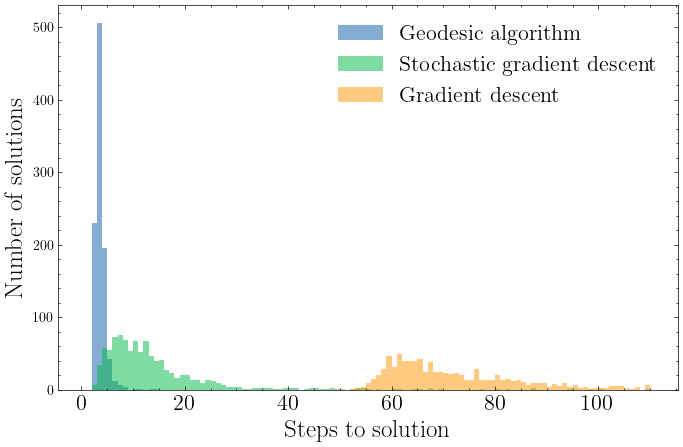

In [14]:
gate = 'toffoli'
ntrials = 1000
commute = True
max_steps = 1000

num_steps_gnd, num_steps_sgd, num_steps_jaxgd = loaded_data[f"{gate}_{ntrials}_{commute}_{max_steps}"]

name = f"plots/{gate}_gate_comparison_max_steps_{max_steps}_commutes_{commute}"
plot_comparison(num_steps_gnd, num_steps_sgd, num_steps_jaxgd, ntrials, name, 
                f"Toffoli ({'Comm.' if commute else 'Non-comm.'})")

### Non-commuting

In [15]:
from gnd.src.configs import ToffoliConfig as ToffoliConfigGnd
from jax_gd.src.configs import ToffoliConfig

config = ToffoliConfig()
config_gnd = ToffoliConfigGnd()

gate = 'toffoli'
ntrials = 1000
commute = False
max_steps = 1000

config.max_steps = max_steps
config_gnd.max_steps = max_steps
config_gnd.commute = commute

seeds = [n*256 for n in range(1,ntrials+1,1)] 

num_steps_gnd, num_steps_sgd, num_steps_jaxgd = get_data_comparison(config, config_gnd, seeds)
loaded_data[f"{gate}_{ntrials}_{commute}_{max_steps}"] = (num_steps_gnd, num_steps_sgd, num_steps_jaxgd)

Data integrity: for seed: 256000
GND: 983/1000
Innocenti: 986/1000
Jax GD: 1000/1000

Number of solutions with fidelity 0.999:
GND: 982/983
Innocenti: 986/986
Jax GD: 981/1000

Mean time to solution 18.66089613034623
Mean time to solution 13.626774847870182
Mean time to solution 80.85117227319063


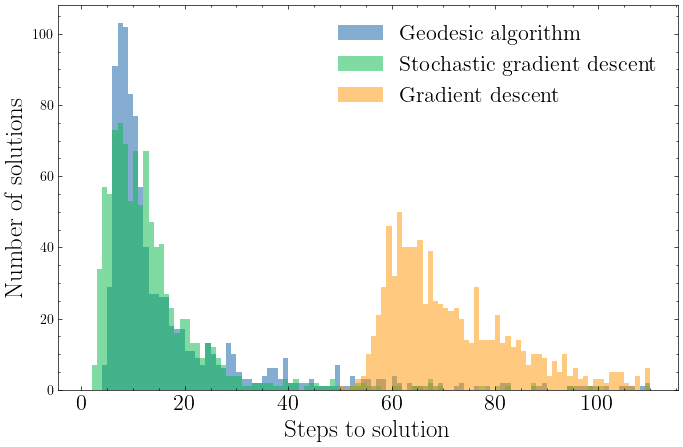

In [16]:
gate = 'toffoli'
ntrials = 1000
commute = False
max_steps = 1000

num_steps_gnd, num_steps_sgd, num_steps_jaxgd = loaded_data[f"{gate}_{ntrials}_{commute}_{max_steps}"]
name = f"plots/{gate}_gate_comparison_max_steps_{max_steps}_commutes_{commute}"
plot_comparison(num_steps_gnd, num_steps_sgd, num_steps_jaxgd, ntrials, name, 
                f"Toffoli ({'Comm.' if commute else 'Non-comm.'})")

# Fredkin

### Commuting

In [17]:
from gnd.src.configs import FredkinConfig as FredkinConfigGnd
from jax_gd.src.configs import FredkinConfig

config = FredkinConfig()
config_gnd = FredkinConfigGnd()

gate = 'fredkin'
ntrials = 1000
commute = True
max_steps = 1000

config.max_steps = max_steps
config_gnd.max_steps = max_steps
config_gnd.commute = commute

seeds = [n*256 for n in range(1,ntrials+1,1)] 

num_steps_gnd, num_steps_sgd, num_steps_jaxgd = get_data_comparison(config, config_gnd, seeds)
loaded_data[f"{gate}_{ntrials}_{commute}_{max_steps}"] = (num_steps_gnd, num_steps_sgd, num_steps_jaxgd)

Data integrity: for seed: 256000
GND: 1000/1000
Innocenti: 994/1000
Jax GD: 1000/1000

Number of solutions with fidelity 0.999:
GND: 993/1000
Innocenti: 994/994
Jax GD: 715/1000

Mean time to solution 7.498489425981873
Mean time to solution 21.367203219315897
Mean time to solution 85.8013986013986


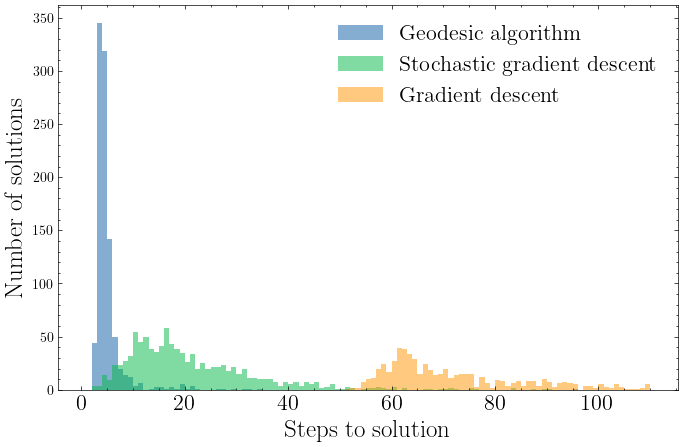

In [18]:
gate = 'fredkin'
ntrials = 1000
commute = True
max_steps = 1000

num_steps_gnd, num_steps_sgd, num_steps_jaxgd = loaded_data[f"{gate}_{ntrials}_{commute}_{max_steps}"]

name = f"plots/{gate}_gate_comparison_max_steps_{max_steps}_commutes_{commute}"
plot_comparison(num_steps_gnd, num_steps_sgd, num_steps_jaxgd, ntrials, name,
                f"Fredkin ({'Comm.' if commute else 'Non-comm.'})")

### Non-commuting

In [19]:
from gnd.src.configs import FredkinConfig as FredkinConfigGnd
from jax_gd.src.configs import FredkinConfig

config = FredkinConfig()
config_gnd = FredkinConfigGnd()

gate = 'fredkin'
ntrials = 1000
commute = False
max_steps = 1000

config.max_steps = max_steps
config_gnd.max_steps = max_steps
config_gnd.commute = commute

seeds = [n*256 for n in range(1,ntrials+1,1)] 

num_steps_gnd, num_steps_sgd, num_steps_jaxgd = get_data_comparison(config, config_gnd, seeds)
loaded_data[f"{gate}_{ntrials}_{commute}_{max_steps}"] = (num_steps_gnd, num_steps_sgd, num_steps_jaxgd)

Data integrity: for seed: 256000
GND: 892/1000
Innocenti: 994/1000
Jax GD: 1000/1000

Number of solutions with fidelity 0.999:
GND: 884/892
Innocenti: 994/994
Jax GD: 715/1000

Mean time to solution 22.631221719457013
Mean time to solution 21.367203219315897
Mean time to solution 85.8013986013986


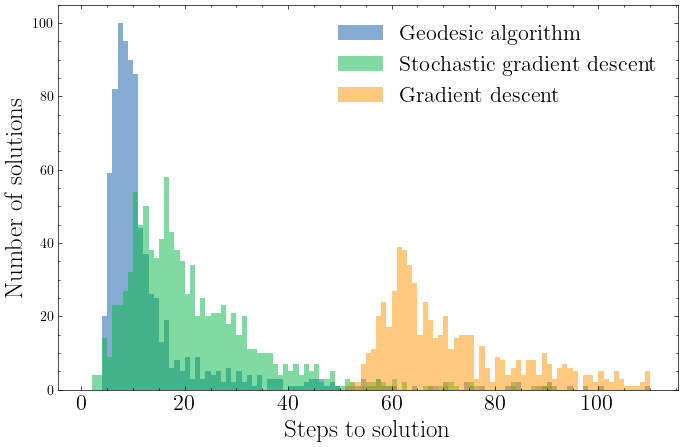

In [20]:
gate = 'fredkin'
ntrials = 1000
commute = False
max_steps = 1000

num_steps_gnd, num_steps_sgd, num_steps_jaxgd = loaded_data[f"{gate}_{ntrials}_{commute}_{max_steps}"]
name = f"plots/{gate}_gate_comparison_max_steps_{max_steps}_commutes_{commute}"
plot_comparison(num_steps_gnd, num_steps_sgd, num_steps_jaxgd, ntrials, name,
                f"Fredkin ({'Comm.' if commute else 'Non-comm.'})")

# C4Not

### Commuting

In [21]:
from gnd.src.configs import CxNotConfig as CxNotConfigGnd
from jax_gd.src.configs import CxNotConfig

config = CxNotConfig(4)
config_gnd = CxNotConfigGnd(4)

gate = 'c4not'
ntrials = 1000
commute = True
max_steps = 5000

config.max_steps = max_steps
config_gnd.max_steps = max_steps
config_gnd.commute = commute

seeds = [n*256 for n in range(1,ntrials+1,1)] 

num_steps_gnd, num_steps_sgd, num_steps_jaxgd = get_data_comparison(config, config_gnd, seeds)
loaded_data[f"{gate}_{ntrials}_{commute}_{max_steps}"] = (num_steps_gnd, num_steps_sgd, num_steps_jaxgd)

Data integrity: for seed: 256000
GND: 1000/1000
Innocenti: 997/1000
Jax GD: 1000/1000

Number of solutions with fidelity 0.999:
GND: 582/1000
Innocenti: 997/997
Jax GD: 189/1000

Mean time to solution 257.16838487972507
Mean time to solution 64.6340206185567
Mean time to solution 277.18518518518516


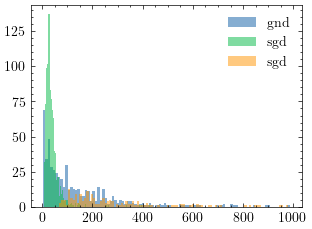

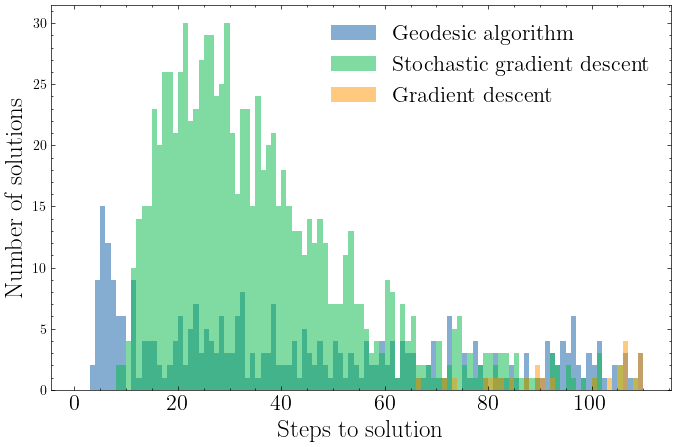

In [22]:
gate = 'c4not'
ntrials = 1000
commute = True
max_steps = 5000

num_steps_gnd, num_steps_sgd, num_steps_jaxgd = loaded_data[f"{gate}_{ntrials}_{commute}_{max_steps}"]
num_steps_gnd=np.array(num_steps_gnd)
num_steps_sgd=np.array(num_steps_sgd)
num_steps_jaxgd=np.array(num_steps_jaxgd)

plt.hist(num_steps_gnd[num_steps_gnd<1000], bins=100, alpha=0.5, label='gnd')
plt.hist(num_steps_sgd[num_steps_sgd<1000], bins=100, alpha=0.5, label='sgd')
plt.hist(num_steps_jaxgd[num_steps_jaxgd<1000], bins=100, alpha=0.5, label='sgd')
plt.legend()
plt.show()
name = f"plots/{gate}_gate_comparison_max_steps_{max_steps}_commutes_{commute}"
plot_comparison(num_steps_gnd, num_steps_sgd, num_steps_jaxgd, ntrials, name,
                f"C4Not ({'Comm.' if commute else 'Non-comm.'})")

### Non-commuting

In [23]:
from gnd.src.configs import CxNotConfig as CxNotConfigGnd
from jax_gd.src.configs import CxNotConfig

config = CxNotConfig(4)
config_gnd = CxNotConfigGnd(4)

gate = 'c4not'
ntrials = 1000
commute = False
max_steps = 5000

config.max_steps = max_steps
config_gnd.max_steps = max_steps
config_gnd.commute = commute

seeds = [n*256 for n in range(1,ntrials+1,1)] 

num_steps_gnd, num_steps_sgd, num_steps_jaxgd = get_data_comparison(config, config_gnd, seeds)
loaded_data[f"{gate}_{ntrials}_{commute}_{max_steps}"] = (num_steps_gnd, num_steps_sgd, num_steps_jaxgd)

Data integrity: for seed: 256000
GND: 1000/1000
Innocenti: 997/1000
Jax GD: 1000/1000

Number of solutions with fidelity 0.999:
GND: 993/1000
Innocenti: 997/997
Jax GD: 189/1000

Mean time to solution 74.31722054380664
Mean time to solution 64.6340206185567
Mean time to solution 277.18518518518516


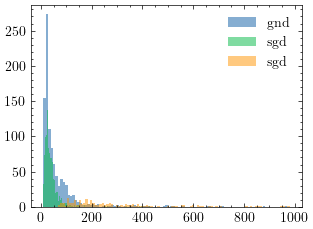

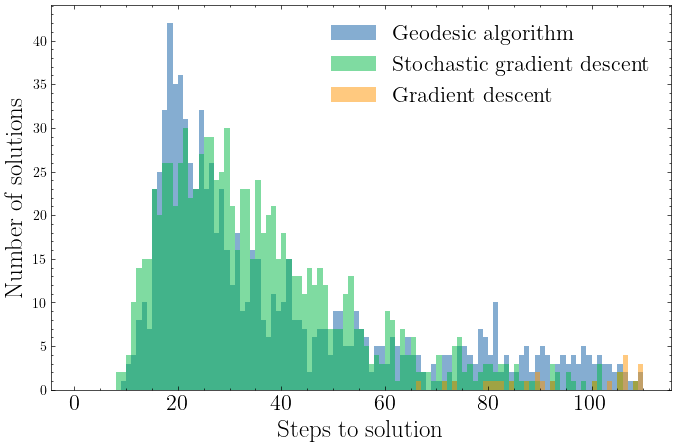

In [24]:
gate = 'c4not'
ntrials = 1000
commute = False
max_steps = 5000

num_steps_gnd, num_steps_sgd, num_steps_jaxgd = loaded_data[f"{gate}_{ntrials}_{commute}_{max_steps}"]
num_steps_gnd=np.array(num_steps_gnd)
num_steps_sgd=np.array(num_steps_sgd)
num_steps_jaxgd=np.array(num_steps_jaxgd)
plt.figure()
plt.hist(num_steps_gnd[num_steps_gnd<1000], bins=100, alpha=0.5, label='gnd')
plt.hist(num_steps_sgd[num_steps_sgd<1000], bins=100, alpha=0.5, label='sgd')
plt.hist(num_steps_jaxgd[num_steps_jaxgd<1000], bins=100, alpha=0.5, label='sgd')
plt.legend()
plt.show()
name = f"plots/{gate}_gate_comparison_max_steps_{max_steps}_commutes_{commute}"
plot_comparison(num_steps_gnd, num_steps_sgd, num_steps_jaxgd, ntrials, name,
                f"C4Not ({'Comm.' if commute else 'Non-comm.'})")

# Fidelity plots
We only consider the non-commuting options here.

# C5Not

### Commuting

In [44]:
from gnd.src.configs import CxNotConfig as CxNotConfigGnd

config = CxNotConfigGnd(5)

gate = 'c5not'
ntrials = 10
commute = True
max_steps = 10000

config.max_steps = max_steps
config.max_steps = max_steps
config.commute = commute

seeds = [n*256 for n in range(1, ntrials+1, 1)] 

num_steps_gnd, max_fidelity_gnd = get_data_fidelity(config, seeds)
num_steps_gnd_traj, max_fidelity_gnd_traj = get_data_fidelity_trajectories(config, seeds)

loaded_data[f"{gate}_{ntrials}_{commute}_{max_steps}_fid"] = (num_steps_gnd, max_fidelity_gnd)
loaded_data[f"{gate}_{ntrials}_{commute}_{max_steps}_fid_traj"] = (num_steps_gnd_traj, max_fidelity_gnd_traj)

Data integrity: for seed: 2560
GND: 9/10
Data integrity: for seed: 2560
GND: 9/10


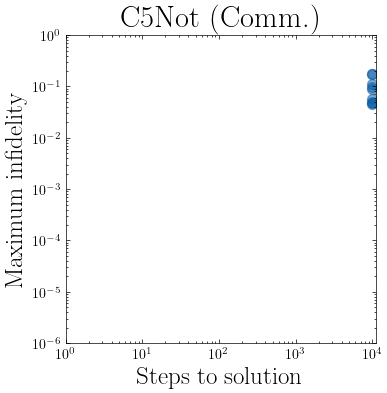

In [45]:
gate = 'c5not'
ntrials = 10
commute = True
max_steps = 10000

num_steps_gnd, max_fidelity_gnd= loaded_data[f"{gate}_{ntrials}_{commute}_{max_steps}_fid"] 
name = f"plots/{gate}_gate_fidelity_max_steps_{max_steps}_commutes_{commute}"
plot_fidelity(num_steps_gnd, max_fidelity_gnd, name, f"C5Not ({'Comm.' if commute else 'Non-comm.'})")

### Non-commuting

In [46]:
from gnd.src.configs import CxNotConfig as CxNotConfigGnd

config = CxNotConfigGnd(5)

gate = 'c5not'
ntrials = 10
commute = False
max_steps = 10000

config.max_steps = max_steps
config.max_steps = max_steps
config.commute = commute

seeds = [n*256 for n in range(1, ntrials+1, 1)] 

num_steps_gnd, max_fidelity_gnd = get_data_fidelity(config, seeds)
num_steps_gnd_traj, max_fidelity_gnd_traj = get_data_fidelity_trajectories(config, seeds)

loaded_data[f"{gate}_{ntrials}_{commute}_{max_steps}_fid"] = (num_steps_gnd, max_fidelity_gnd)
loaded_data[f"{gate}_{ntrials}_{commute}_{max_steps}_fid_traj"] = (num_steps_gnd_traj, max_fidelity_gnd_traj)

Data integrity: for seed: 2560
GND: 10/10
Data integrity: for seed: 2560
GND: 10/10


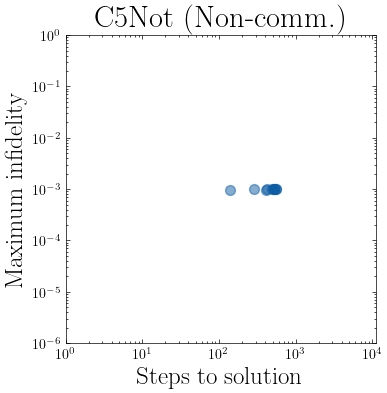

In [47]:
gate = 'c5not'
ntrials = 10
commute = False
max_steps = 10000

num_steps_gnd, max_fidelity_gnd = loaded_data[f"{gate}_{ntrials}_{commute}_{max_steps}_fid"] 
name = f"plots/{gate}_gate_fidelity_max_steps_{max_steps}_commutes_{commute}"
plot_fidelity(num_steps_gnd, max_fidelity_gnd, name, f"C5Not ({'Comm.' if commute else 'Non-comm.'})")

# Weight3ParityX

### Commuting

In [48]:
from gnd.src.configs import Weight3ParityXConfig

config = Weight3ParityXConfig()

gate = 'w3px'
ntrials = 10
commute = True
max_steps = 10000

config.max_steps = max_steps
config.max_steps = max_steps
config.commute = commute

seeds = [n*256 for n in range(1, ntrials+1, 1)] 

num_steps_gnd, max_fidelity_gnd = get_data_fidelity(config, seeds)
num_steps_gnd_traj, max_fidelity_gnd_traj = get_data_fidelity_trajectories(config, seeds)

loaded_data[f"{gate}_{ntrials}_{commute}_{max_steps}_fid"] = (num_steps_gnd, max_fidelity_gnd)
loaded_data[f"{gate}_{ntrials}_{commute}_{max_steps}_fid_traj"] = (num_steps_gnd_traj, max_fidelity_gnd_traj)

Data integrity:
GND: 0/10
Data integrity:
GND: 0/10


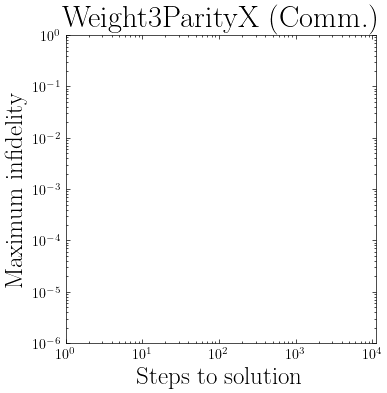

In [49]:
gate = 'w3px'
ntrials = 10
commute = True
max_steps = 10000

num_steps_gnd, max_fidelity_gnd = loaded_data[f"{gate}_{ntrials}_{commute}_{max_steps}_fid"] 
name = f"plots/{gate}_gate_fidelity_max_steps_{max_steps}_commutes_{commute}"
plot_fidelity(num_steps_gnd, max_fidelity_gnd, name, f"Weight3ParityX ({'Comm.' if commute else 'Non-comm.'})")

### Non-commuting

In [50]:
from gnd.src.configs import Weight3ParityXConfig

config = Weight3ParityXConfig()

gate = 'w3px'
ntrials = 10
commute = False
max_steps = 10000

config.max_steps = max_steps
config.max_steps = max_steps
config.commute = commute

seeds = [n*256 for n in range(1, ntrials+1, 1)] 

num_steps_gnd, max_fidelity_gnd = get_data_fidelity(config, seeds)
num_steps_gnd_traj, max_fidelity_gnd_traj = get_data_fidelity_trajectories(config, seeds)

loaded_data[f"{gate}_{ntrials}_{commute}_{max_steps}_fid"] = (num_steps_gnd, max_fidelity_gnd)
loaded_data[f"{gate}_{ntrials}_{commute}_{max_steps}_fid_traj"] = (num_steps_gnd_traj, max_fidelity_gnd_traj)

Data integrity: for seed: 2560
GND: 6/10
Data integrity: for seed: 2560
GND: 6/10


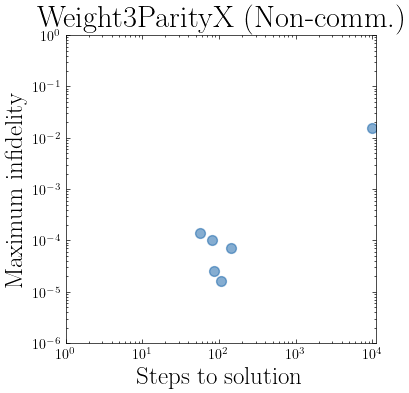

In [51]:
gate = 'w3px'
ntrials = 10
commute = False
max_steps = 10000

num_steps_gnd, max_fidelity_gnd = loaded_data[f"{gate}_{ntrials}_{commute}_{max_steps}_fid"] 
name = f"plots/{gate}_gate_fidelity_max_steps_{max_steps}_commutes_{commute}"
plot_fidelity(num_steps_gnd, max_fidelity_gnd, name, f"Weight3ParityX ({'Comm.' if commute else 'Non-comm.'})")

# Weight3ParityZ

### Commuting

In [52]:
from gnd.src.configs import Weight3ParityZConfig

config = Weight3ParityZConfig()

gate = 'w3pz'
ntrials = 10
commute = True
max_steps = 10000

config.max_steps = max_steps
config.max_steps = max_steps
config.commute = commute

seeds = [n*256 for n in range(1, ntrials+1, 1)] 

num_steps_gnd, max_fidelity_gnd = get_data_fidelity(config, seeds)
num_steps_gnd_traj, max_fidelity_gnd_traj = get_data_fidelity_trajectories(config, seeds)

loaded_data[f"{gate}_{ntrials}_{commute}_{max_steps}_fid"] = (num_steps_gnd, max_fidelity_gnd)
loaded_data[f"{gate}_{ntrials}_{commute}_{max_steps}_fid_traj"] = (num_steps_gnd_traj, max_fidelity_gnd_traj)

Data integrity: for seed: 2560
GND: 10/10
Data integrity: for seed: 2560
GND: 10/10


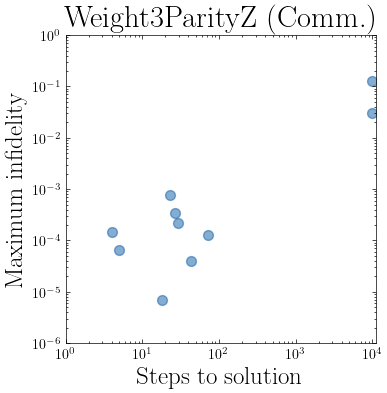

In [53]:
gate = 'w3pz'
ntrials = 10
commute = True
max_steps = 10000

num_steps_gnd, max_fidelity_gnd= loaded_data[f"{gate}_{ntrials}_{commute}_{max_steps}_fid"] 
name = f"plots/{gate}_gate_fidelity_max_steps_{max_steps}_commutes_{commute}"
plot_fidelity(num_steps_gnd, max_fidelity_gnd, name, f"Weight3ParityZ ({'Comm.' if commute else 'Non-comm.'})")

### Non-commuting

In [54]:
from gnd.src.configs import Weight3ParityZConfig

config = Weight3ParityZConfig()

gate = 'w3pz'
ntrials = 10
commute = False
max_steps = 10000

config.max_steps = max_steps
config.max_steps = max_steps
config.commute = commute

seeds = [n*256 for n in range(1, ntrials+1, 1)] 

num_steps_gnd, max_fidelity_gnd = get_data_fidelity(config, seeds)
num_steps_gnd_traj, max_fidelity_gnd_traj = get_data_fidelity_trajectories(config, seeds)

loaded_data[f"{gate}_{ntrials}_{commute}_{max_steps}_fid"] = (num_steps_gnd, max_fidelity_gnd)
loaded_data[f"{gate}_{ntrials}_{commute}_{max_steps}_fid_traj"] = (num_steps_gnd_traj, max_fidelity_gnd_traj)

Data integrity: for seed: 2560
GND: 8/10
Data integrity: for seed: 2560
GND: 8/10


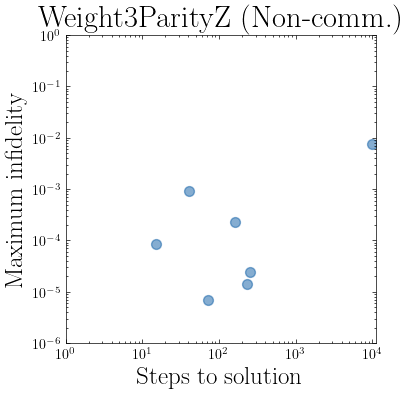

In [55]:
gate = 'w3pz'
ntrials = 10
commute = False
max_steps = 10000

num_steps_gnd, max_fidelity_gnd = loaded_data[f"{gate}_{ntrials}_{commute}_{max_steps}_fid"] 
name = f"plots/{gate}_gate_fidelity_max_steps_{max_steps}_commutes_{commute}"
plot_fidelity(num_steps_gnd, max_fidelity_gnd, name, f"Weight3ParityZ ({'Comm.' if commute else 'Non-comm.'})")

# Weight4ParityX

### Commuting

In [56]:
from gnd.src.configs import Weight4ParityXConfig

config = Weight4ParityXConfig()

gate = 'w4px'
ntrials = 10
commute = True
max_steps = 10000

config.max_steps = max_steps
config.max_steps = max_steps
config.commute = commute

seeds = [n*256 for n in range(1, ntrials+1, 1)] 

num_steps_gnd, max_fidelity_gnd = get_data_fidelity(config, seeds)
num_steps_gnd_traj, max_fidelity_gnd_traj = get_data_fidelity_trajectories(config, seeds)

loaded_data[f"{gate}_{ntrials}_{commute}_{max_steps}_fid"] = (num_steps_gnd, max_fidelity_gnd)
loaded_data[f"{gate}_{ntrials}_{commute}_{max_steps}_fid_traj"] = (num_steps_gnd_traj, max_fidelity_gnd_traj)

Data integrity:
GND: 0/10
Data integrity:
GND: 0/10


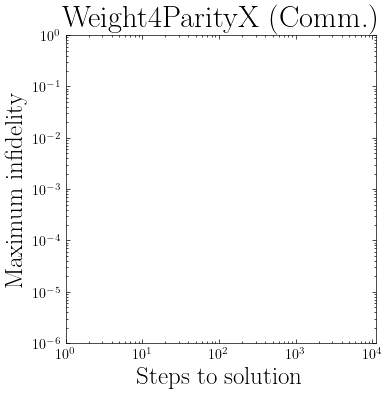

In [57]:
gate = 'w4px'
ntrials = 10
commute = True
max_steps = 10000

num_steps_gnd, max_fidelity_gnd = loaded_data[f"{gate}_{ntrials}_{commute}_{max_steps}_fid"] 
name = f"plots/{gate}_gate_fidelity_max_steps_{max_steps}_commutes_{commute}"
plot_fidelity(num_steps_gnd, max_fidelity_gnd, name, f"Weight4ParityX ({'Comm.' if commute else 'Non-comm.'})")

### Non-commuting

In [58]:
from gnd.src.configs import Weight4ParityXConfig

config = Weight4ParityXConfig()

gate = 'w4px'
ntrials = 10
commute = False
max_steps = 10000

config.max_steps = max_steps
config.max_steps = max_steps
config.commute = commute

seeds = [n*256 for n in range(1, ntrials+1, 1)] 

num_steps_gnd, max_fidelity_gnd = get_data_fidelity(config, seeds)
num_steps_gnd_traj, max_fidelity_gnd_traj = get_data_fidelity_trajectories(config, seeds)

loaded_data[f"{gate}_{ntrials}_{commute}_{max_steps}_fid"] = (num_steps_gnd, max_fidelity_gnd)
loaded_data[f"{gate}_{ntrials}_{commute}_{max_steps}_fid_traj"] = (num_steps_gnd_traj, max_fidelity_gnd_traj)

Data integrity: for seed: 2560
GND: 8/10
Data integrity: for seed: 2560
GND: 8/10


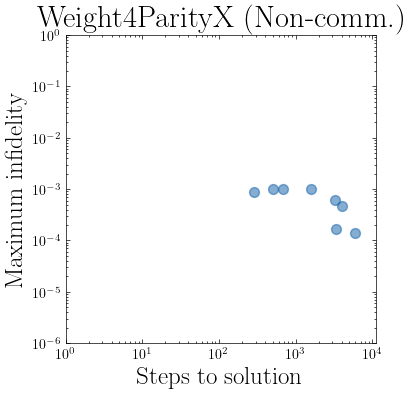

In [59]:
gate = 'w4px'
ntrials = 10
commute = False
max_steps = 10000

num_steps_gnd, max_fidelity_gnd = loaded_data[f"{gate}_{ntrials}_{commute}_{max_steps}_fid"] 
name = f"plots/{gate}_gate_fidelity_max_steps_{max_steps}_commutes_{commute}"
plot_fidelity(num_steps_gnd, max_fidelity_gnd, name, f"Weight4ParityX ({'Comm.' if commute else 'Non-comm.'})")

# Weight4ParityZ

### commuting

In [60]:
from gnd.src.configs import Weight4ParityZConfig

config = Weight4ParityZConfig()

gate = 'w4pz'
ntrials = 10
commute = True
max_steps = 10000

config.max_steps = max_steps
config.max_steps = max_steps
config.commute = commute

seeds = [n*256 for n in range(1, ntrials+1, 1)] 

num_steps_gnd, max_fidelity_gnd = get_data_fidelity(config, seeds)
num_steps_gnd_traj, max_fidelity_gnd_traj = get_data_fidelity_trajectories(config, seeds)

loaded_data[f"{gate}_{ntrials}_{commute}_{max_steps}_fid"] = (num_steps_gnd, max_fidelity_gnd)
loaded_data[f"{gate}_{ntrials}_{commute}_{max_steps}_fid_traj"] = (num_steps_gnd_traj, max_fidelity_gnd_traj)

Data integrity: for seed: 2560
GND: 5/10
Data integrity: for seed: 2560
GND: 5/10


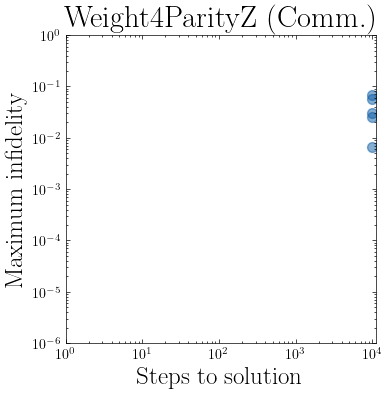

In [61]:
gate = 'w4pz'
ntrials = 10
commute = True
max_steps = 10000

num_steps_gnd, max_fidelity_gnd = loaded_data[f"{gate}_{ntrials}_{commute}_{max_steps}_fid"] 
name = f"plots/{gate}_gate_fidelity_max_steps_{max_steps}_commutes_{commute}"
plot_fidelity(num_steps_gnd, max_fidelity_gnd, name, f"Weight4ParityZ ({'Comm.' if commute else 'Non-comm.'})")

### Non-commuting

In [62]:
from gnd.src.configs import Weight4ParityZConfig

config = Weight4ParityZConfig()

gate = 'w4pz'
ntrials = 10
commute = False
max_steps = 10000

config.max_steps = max_steps
config.max_steps = max_steps
config.commute = commute

seeds = [n*256 for n in range(1, ntrials+1, 1)] 

num_steps_gnd, max_fidelity_gnd = get_data_fidelity(config, seeds)
num_steps_gnd_traj, max_fidelity_gnd_traj = get_data_fidelity_trajectories(config, seeds)

loaded_data[f"{gate}_{ntrials}_{commute}_{max_steps}_fid"] = (num_steps_gnd, max_fidelity_gnd)
loaded_data[f"{gate}_{ntrials}_{commute}_{max_steps}_fid_traj"] = (num_steps_gnd_traj, max_fidelity_gnd_traj)

Data integrity: for seed: 2560
GND: 7/10
Data integrity: for seed: 2560
GND: 7/10


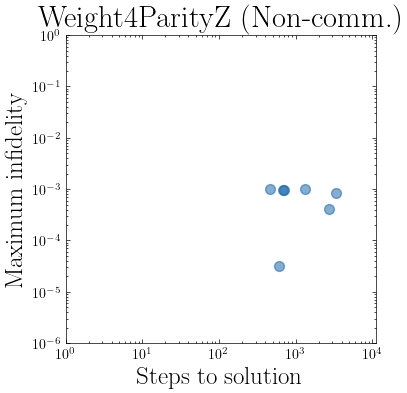

In [63]:
gate = 'w4pz'
ntrials = 10
commute = False
max_steps = 10000

num_steps_gnd, max_fidelity_gnd = loaded_data[f"{gate}_{ntrials}_{commute}_{max_steps}_fid"] 
name = f"plots/{gate}_gate_fidelity_max_steps_{max_steps}_commutes_{commute}"
plot_fidelity(num_steps_gnd, max_fidelity_gnd, name, f"Weight4ParityZ ({'Comm.' if commute else 'Non-comm.'})")

# Combined Fidelity plot

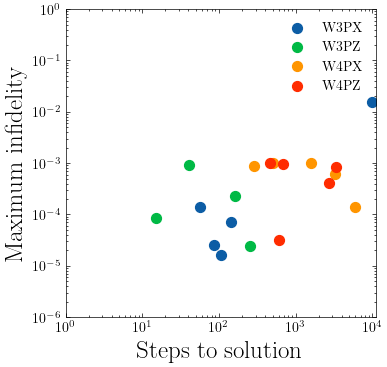

In [74]:
ntrials = 10
commute = False
max_steps = 10000
gate_list = ['w3px','w3pz','w4px','w4pz']

fig, axs = plt.subplots(1,1)
fig.set_size_inches(4,4)
    
for gate in gate_list:
    num_steps_gnd, max_fidelity_gnd = loaded_data[f"{gate}_{ntrials}_{commute}_{max_steps}_fid"]
    axs.scatter(num_steps_gnd[:5], 1 -  np.abs(max_fidelity_gnd)[:5], s=50, label=f"{gate.upper()}")
axs.set_xlabel(f"Steps to solution", fontsize=fontsize_label)
axs.set_ylabel(f"Maximum infidelity", fontsize=fontsize_label)
axs.set_yscale('log')
axs.set_xscale('log')
axs.set_xlim(1, 10**4+1000)
axs.set_ylim(1e-6, 1.)
plt.legend()
plt.savefig(f"./plots/weighted_parity_combined_commute_{commute}.pdf", bbox_inches='tight')
plt.show()

# Plot trajectories

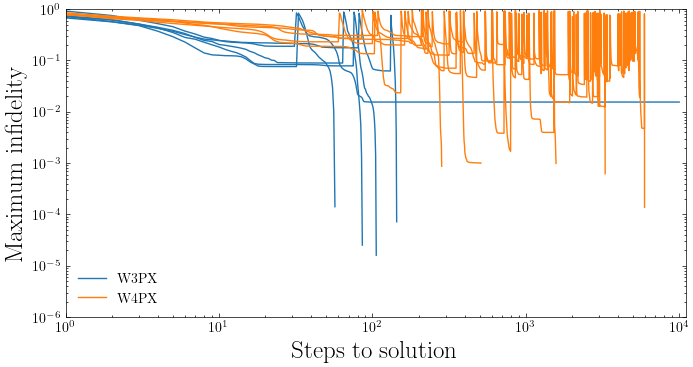

In [76]:
ntrials = 10
commute = False
max_steps = 10000
gate_list = ['w3px','w4px']
# gate_list = ['w3px','w3pz','w4px','w4pz']

fig, axs = plt.subplots(1,1)
fig.set_size_inches(8,4)
num_traj = 5
cmap = plt.get_cmap('tab10')
colors = [cmap(i*0.1) for i in range(len(gate_list))]
for j, gate in enumerate(gate_list):
    steps_gnd, fidelity_gnd = loaded_data[f"{gate}_{ntrials}_{commute}_{max_steps}_fid_traj"]
    for i in range(num_traj):
        if not i:
            axs.plot(steps_gnd[i], 1 -  np.abs(fidelity_gnd[i]), label=f"{gate.upper()}", color=colors[j])
        else:
            axs.plot(steps_gnd[i], 1 -  np.abs(fidelity_gnd[i]), color=colors[j])
axs.set_xlabel(f"Steps to solution", fontsize=fontsize_label)
axs.set_ylabel(f"Maximum infidelity", fontsize=fontsize_label)
axs.set_yscale('log')
axs.set_xscale('log')
axs.set_xlim(1, 10**4+1000)
axs.set_ylim(1e-6, 1.)
plt.legend()
plt.savefig(f"./plots/weighted_parity_fidelities_{commute}.pdf", bbox_inches='tight')
plt.show()